In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from koala.example_graphs import generate_hex_square_oct,generate_honeycomb,generate_tri_non
from koala.graph_color import color_lattice
from koala.pointsets import generate_bluenoise
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.plotting import plot_lattice, peru_friendly_colour_scheme

first we look at 4 examples of small systems and find the ground state by exhaustively searching the parameter space

In [34]:

honeycomb = generate_honeycomb(3,True)

hex_squre_oct = generate_hex_square_oct(2)
hso_colouring = color_lattice(hex_squre_oct)

three_nine = generate_tri_non([3,2], True)

points = generate_bluenoise(30,4,4)
amorphous = generate_lattice(points)
am_colouring = color_lattice(amorphous)

lattice_systems = [
    honeycomb[0],
    hex_squre_oct,
    three_nine[0],
    amorphous
]

colourings = [
    honeycomb[1],
    hso_colouring,
    three_nine[1],
    am_colouring
]

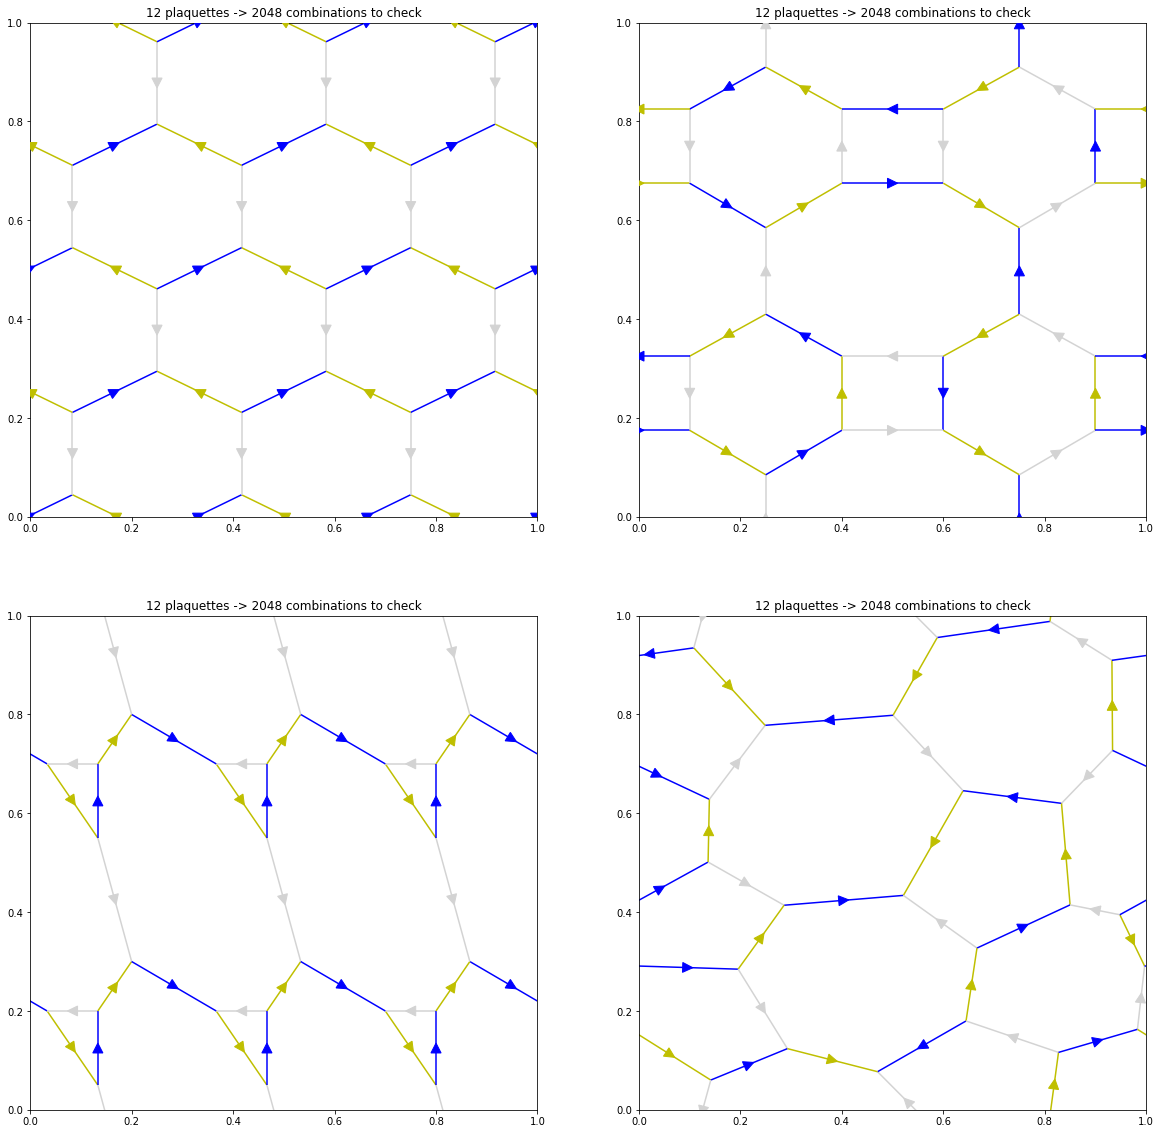

In [35]:
colour_scheme = peru_friendly_colour_scheme(3)

n_systems = len(lattice_systems)
plot_sides = int(np.ceil(n_systems/2))

fig, axes = plt.subplots(2, plot_sides, figsize = (20,10*plot_sides))

for n,lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    plot_lattice(lattice, ax= ax, edge_labels=colourings[n], edge_color_scheme= colour_scheme, edge_arrows = True)
    ax.set_title(f'{lattice.n_plaquettes} plaquettes -> {2**(lattice.n_plaquettes-1)} combinations to check')


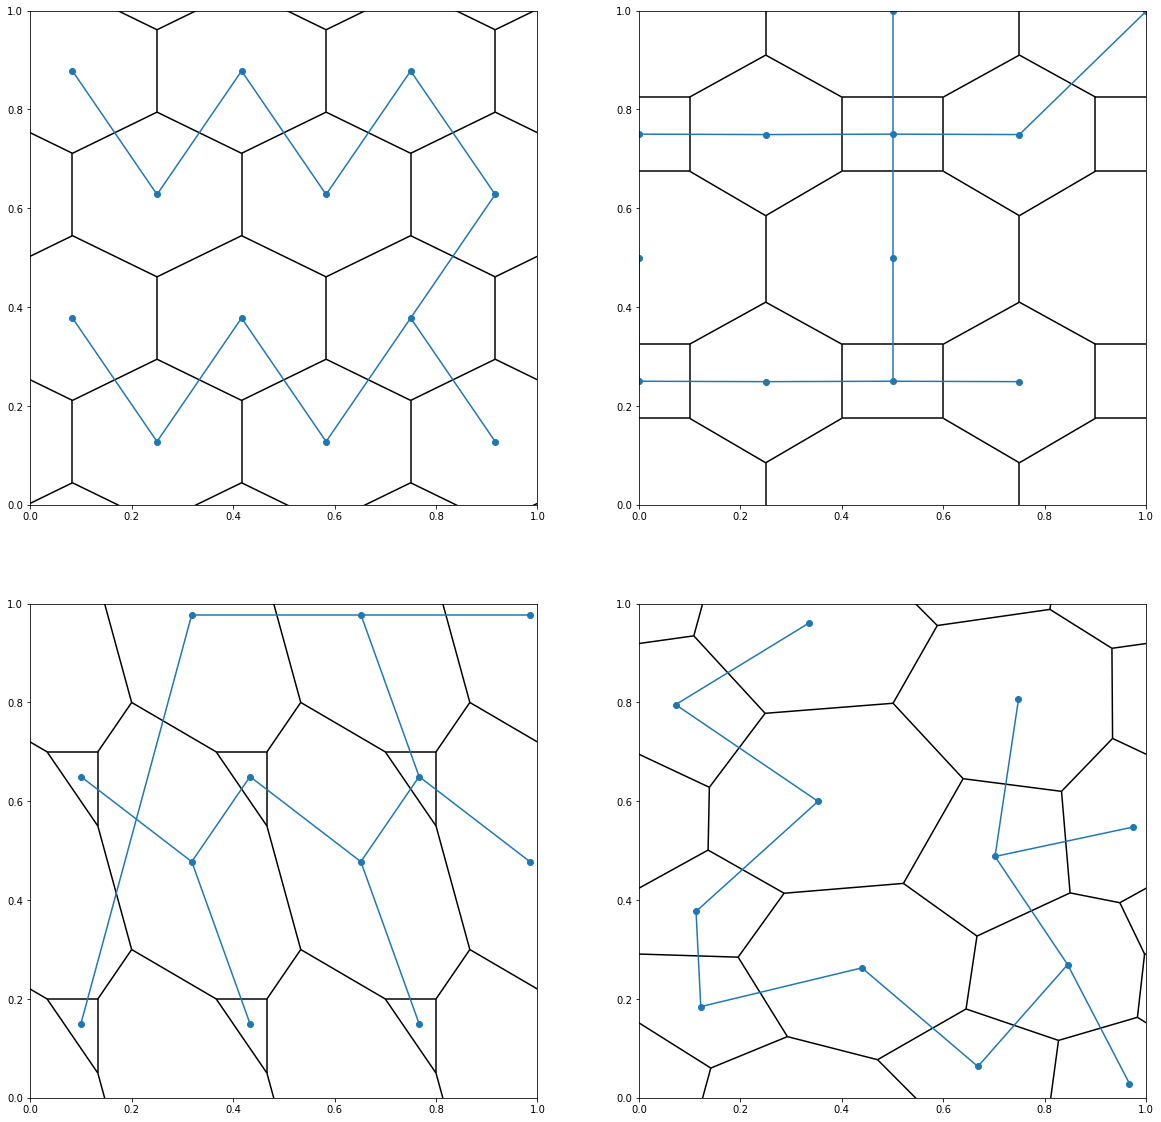

In [36]:
from koala.graph_utils import plaquette_spaning_tree
from matplotlib.collections import LineCollection

spanning_trees = [plaquette_spaning_tree(lat) for lat in lattice_systems]

fig, axes = plt.subplots(2, plot_sides, figsize = (20,10*plot_sides))


for n, lattice in enumerate(lattice_systems):
    ax = axes.flatten()[n]
    edges_in_tree = spanning_trees[n]
    plot_lattice(lattice, ax= ax)
    centers = np.array([p.center for p in lattice.plaquettes])
    ax.scatter(centers[:,0], centers[:,1])

    lines = np.zeros((len(edges_in_tree), 2, 2))

    for n,edge in enumerate(edges_in_tree):
        plaquettes = lattice.edges.adjacent_plaquettes[edge]
        centre = np.zeros((2,2))
        centre[0,:] = lattice.plaquettes[plaquettes[0]].center
        centre[1,:] = lattice.plaquettes[plaquettes[1]].center
        lines[n] = centre


    lc = LineCollection(lines)
    ax.add_collection(lc)



In [37]:
from koala.lattice import Lattice

def construct_Ajk(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray):
    
    edge_type_list = J_values[edge_colouring]
    ujk_phases = 1-2*ujk
    bond_values = 2*edge_type_list*ujk_phases

    ham = np.zeros((lattice.n_vertices, lattice.n_vertices))
    ham[lattice.edges.indices[:,0], lattice.edges.indices[:,1]] = bond_values
    ham[lattice.edges.indices[:,1], lattice.edges.indices[:,0]] = -bond_values

    return ham

def find_ground_state_energy(lattice: Lattice, edge_colouring: np.ndarray, ujk: np.ndarray, J_values: np.ndarray):
    ham = construct_Ajk(lattice,edge_colouring,ujk,J_values)
    energies = np.linalg.eigvalsh(1j*ham)
    energy = -np.sum(np.abs(energies))/4
    return energy

In [89]:
# now set default ujk values for all of them
ujk_values = []
for lattice in lattice_systems:
    ujk = np.full(lattice.n_edges, 1)
    ujk_values.append(ujk)

In [95]:
J_vals = np.array([1,1,1])

all_energies = []


for n,system in enumerate(lattice_systems):
    e_vals = np.zeros(2**11)

    for a in range(2**11):
        string_version = np.binary_repr(a,width = 11)
        flip_key = np.array([int(x) for x in string_version])
        index_flips = np.where(flip_key)[0]
        edges_to_flip = spanning_trees[n][index_flips]

        ujk_for_run = ujk_values[n].copy()
        ujk_for_run[edges_to_flip] = -1
        
        energy = find_ground_state_energy(system, colourings[n],ujk_for_run,J_vals)
        e_vals[a] = energy
    all_energies.append(e_vals)

    

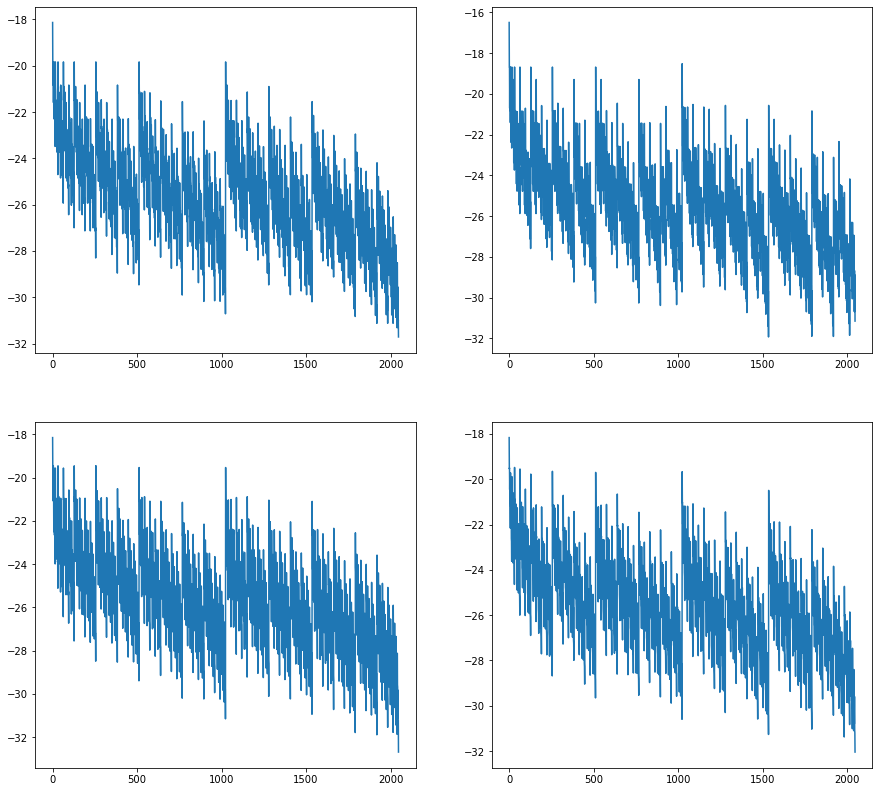

In [98]:
fig, axes = plt.subplots(2, plot_sides, figsize = (15,7*plot_sides))

for n, lattice in enumerate(lattice_systems):
    axes.flatten()[n].plot(all_energies[n])


In [97]:
for en in all_energies:
    print(np.argmin(en))

2047
1535
2047
2047
